In [31]:
import pandas as pd
import numpy as np
import re
import csv

FILE = "H:\\folder\\Day_1\\Day_4\\CarsDatasets2025.csv"


# ---------- 1) Robust read ----------
def read_csv(path):
    # try utf-8; fall back to latin1/cp1252; use Python engine for odd rows
    encodings = ["utf-8", "latin1", "cp1252"]
    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(
                path,
                encoding=enc,
                engine="python",
                skip_blank_lines=True,
                on_bad_lines="skip",            # skip lines with wildly wrong comma counts
                quoting=csv.QUOTE_MINIMAL,
                skipinitialspace=True
            )

            return df
        except Exception as e:
            last_err = e
    raise last_err

df = read_csv(FILE)

'''
Key parameters & options (what they mean + good defaults)

encoding: character set for decoding bytes → text.
Common: "utf-8" (best), "latin1"/"cp1252" (Windows/Excel exports).

engine:
"c" (default): fastest, stricter; may choke on malformed rows.
"python": slower, tolerant to odd quoting/comma mismatches.

on_bad_lines (pandas ≥ 1.3):
"error" (default): raise on malformed lines.
"warn": log a warning, skip line (older pandas).
"skip": silently skip bad lines (your choice).

quoting:
csv.QUOTE_MINIMAL (default): quote only when needed.
csv.QUOTE_ALL: quote all fields (useful when writing).
skipinitialspace=True: trims spaces immediately after delimiters.

Other useful knobs you might add later:
sep=";" (non-comma delimiters)
thousands="," (parse numbers with thousands separators)
dtype={...} (enforce column dtypes)
usecols=[...] (load subset of columns)
na_values=[...] (custom missing markers)
low_memory=False (more accurate type inference, higher memory)
memory_map=True (faster IO on large files)
nrows=... (read a sample for schema detection)
'''

'\nKey parameters & options (what they mean + good defaults)\n\nencoding: character set for decoding bytes → text.\nCommon: "utf-8" (best), "latin1"/"cp1252" (Windows/Excel exports).\n\nengine:\n"c" (default): fastest, stricter; may choke on malformed rows.\n"python": slower, tolerant to odd quoting/comma mismatches.\n\non_bad_lines (pandas ≥ 1.3):\n"error" (default): raise on malformed lines.\n"warn": log a warning, skip line (older pandas).\n"skip": silently skip bad lines (your choice).\n\nquoting:\ncsv.QUOTE_MINIMAL (default): quote only when needed.\ncsv.QUOTE_ALL: quote all fields (useful when writing).\nskipinitialspace=True: trims spaces immediately after delimiters.\n\nOther useful knobs you might add later:\nsep=";" (non-comma delimiters)\nthousands="," (parse numbers with thousands separators)\ndtype={...} (enforce column dtypes)\nusecols=[...] (load subset of columns)\nna_values=[...] (custom missing markers)\nlow_memory=False (more accurate type inference, higher memory)\n

In [32]:
# ---------- 2) Header normalization ----------
def normalize_cols(cols):
    out = []
    for c in cols:
        c = str(c)                  # ensure string
        c = c.strip()                 # trim leading/trailing spaces
        c = c.replace("\xa0", " ")                 # replace non-breaking space (common in Excel exports)
        c = re.sub(r"\s+", "_", c)                 # replace any whitespace (space, tab) with underscore
        c = c.replace("/", "_").replace("(", "_").replace(")", "_").replace("-", "_")# map common symbols to underscores
        c = re.sub(r"__+", "_", c)                 # collapse multiple underscores to one
        c = re.sub(r"[^0-9a-zA-Z_]", "", c)        # strip anything that’s not alphanumeric or underscore
        c = c.strip("_")                 # remove underscores at start/end
        out.append(c)                 
    return out

df.columns = normalize_cols(df.columns)

# Quick peek
print(df.shape)
df.head(3)

'''
3) Why we use this

Code safety: messy headers break attribute access (df.Car Name ❌, df.Car_Name ✅).
Consistency: avoids duplicate headers like "Price " vs "Price".
Portability: ensures headers are valid Python identifiers if you later export to SQL/Parquet/JSON.
Ease of regex/plotting: many tools hate special chars in column names.
'''


(1218, 11)


'\n3) Why we use this\n\nCode safety: messy headers break attribute access (df.Car Name ❌, df.Car_Name ✅).\nConsistency: avoids duplicate headers like "Price " vs "Price".\nPortability: ensures headers are valid Python identifiers if you later export to SQL/Parquet/JSON.\nEase of regex/plotting: many tools hate special chars in column names.\n'

In [33]:
# ---------- 3) Helpers to clean numbers ----------
def to_number(x):
    """Extract numbers from messy strings. Handles commas, currency, units,
    and ranges like '12,000—15,000' (averages)."""
    if pd.isna(x): 
        return np.nan
    s = str(x)
    s = s.replace("\xa0", " ")                     # non breaking space removal
    s = s.replace(",", "")                         #remove excess commas
    s = s.replace("—", "-").replace("–", "-")      # normalize dashes
    # remove obvious text tokens
    s = re.sub(r"(km/h|sec|hp|Nm|cc|batt|battery|KM/H|Math input error)", "", s, flags=re.I)
    # keep digits, dot, sign, dash
    nums = re.findall(r"[-+]?\d*\.?\d+", s)
    if not nums:
        return np.nan
    vals = [float(n) for n in nums]
    return float(np.mean(vals))  # average if it's a range

def clean_torque(x):
    return to_number(x)

def clean_price(x):
    # remove currency symbols then reuse to_number (handles ranges)
    if pd.isna(x): 
        return np.nan
    s = str(x).replace("$", "").replace("₹", "").replace("€", "").replace("£","")
    return to_number(s)

def first_number(x):
    """Grab the first meaningful number (useful for CC/Battery_Capacity)."""
    if pd.isna(x): 
        return np.nan
    s = str(x).replace(",", "")
    m = re.search(r"\d*\.?\d+", s)
    return float(m.group()) if m else np.nan



In [34]:
# ---------- 4) Column-specific cleaning ----------
# rename likely columns to predictable names if present
rename_map = {
    "Cars_Prices": "price",
    "Cars_PricesKMH": "price",   # just in case header mangled
    "Performance0___100__KMH": "perf_0_100_s",
    "Performance0__100__KMH": "perf_0_100_s",
    "Performance0__100__": "perf_0_100_s",
    "Performance0___100_": "perf_0_100_s",
    "Total_Speed": "top_speed_kmh",
    "HorsePower": "horsepower",
    "Seats": "seats",
    "Torque": "torque_nm",
    "CC_Battery_Capacity": "cc_capacity",
    "CCBattery_Capacity": "cc_capacity",
}
df = df.rename(columns={c: rename_map.get(c, c) for c in df.columns})

# Clean numeric-ish columns if they exist
if "horsepower" in df:
    df["horsepower"] = df["horsepower"].apply(to_number)

if "top_speed_kmh" in df:
    df["top_speed_kmh"] = df["top_speed_kmh"].apply(to_number)

# Handle multiple performance header variants
perf_cols = [c for c in df.columns if c.lower().startswith("performance")]
for c in perf_cols:
    df[c] = df[c].apply(to_number)
    df = df.rename(columns={c: "perf_0_100_s"})  # unify name to one column
# If multiple perf columns ended up the same name, keep first non-null
if "perf_0_100_s" in df:
    if isinstance(df["perf_0_100_s"], pd.core.series.Series):
        pass

if "price" in df:
    df["price"] = df["price"].apply(clean_price)

'''
Removes ₹/$/€/£, commas, ranges.
Example: "₹25,00,000–₹30,00,000" → 2750000.0.
'''

if "torque_nm" in df:
    df["torque_nm"] = df["torque_nm"].apply(clean_torque)

'''
Ensures torque is numeric (320 Nm → 320.0).
'''

if "seats" in df:
    df["seats"] = pd.to_numeric(df["seats"], errors="coerce")

'''
Converts string seats ("5" or "5-seater") → 5.
errors="coerce" → invalid values become NaN.
'''

if "cc_capacity" in df:
    df["cc_capacity"] = df["cc_capacity"].apply(first_number)

'''
Extracts first number only.
"1497 cc (1.5L)" → 1497.
"5000–5500 mAh" → 5000.
'''

'\nExtracts first number only.\n"1497 cc (1.5L)" → 1497.\n"5000–5500 mAh" → 5000.\n'

In [35]:
# ---------- 5) Trim whitespace in object columns ----------
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})
# dictionary

'''
df.select_dtypes(include="object").columns
* Selects all columns with dtype "object" (usually strings / categorical text).

astype(str)
Forces every value into a string (even NaN becomes "nan").
* Prevents crashes if some cells are numbers but the column is mixed-type.

.str.strip()
Removes leading/trailing whitespace.
Example: " Petrol " → "Petrol".
Avoids treating "Diesel" and "Diesel " as two categories.

.replace({"nan": np.nan})
Converts the literal string "nan" (from astype(str)) back into a proper np.nan.
* Ensures missing values are consistently recognized as NaN (which pandas/numpy understand).
'''

'\ndf.select_dtypes(include="object").columns\n* Selects all columns with dtype "object" (usually strings / categorical text).\n\nastype(str)\nForces every value into a string (even NaN becomes "nan").\n* Prevents crashes if some cells are numbers but the column is mixed-type.\n\n.str.strip()\nRemoves leading/trailing whitespace.\nExample: " Petrol " → "Petrol".\nAvoids treating "Diesel" and "Diesel " as two categories.\n\n.replace({"nan": np.nan})\nConverts the literal string "nan" (from astype(str)) back into a proper np.nan.\n* Ensures missing values are consistently recognized as NaN (which pandas/numpy understand).\n'

In [36]:
# ---------- 6) Basic sanity filters (optional) ----------
# Remove rows that are clearly broken after parsing (e.g., no car name & no company)
key_text_cols = [c for c in ["Company_Names", "Cars_Names", "CompanyNames", "CarsNames"] if c in df.columns]
if key_text_cols:
    keep_mask = np.zeros(len(df), dtype=bool)
    #np.zeros(len(df), dtype=bool) → start with all False (assume all rows are bad).
    for c in key_text_cols:
        keep_mask |= df[c].notna() & (df[c].astype(str).str.len() > 0)
        '''
        df[c].notna() → keep only non-null rows.
        .astype(str).str.len() > 0 → ensure text isn’t just "".
        Combine conditions with &.
        '''
    df = df[keep_mask]



In [37]:
# ---------- 7) Final check & save ----------
print("\nDtypes:\n", df.dtypes)
print("\nSample:\n", df.head(8))
print("\nMissing per column:\n", df.isna().sum())

df.to_csv("CarsDatasetCleaned.csv", index=False)
print("Cleaned dataset saved as CarsDataset_Cleaned.csv")



Dtypes:
 Company_Names     object
Cars_Names        object
Engines           object
cc_capacity      float64
horsepower       float64
top_speed_kmh    float64
perf_0_100_s     float64
price            float64
Fuel_Types        object
seats            float64
torque_nm        float64
dtype: object

Sample:
   Company_Names            Cars_Names      Engines  cc_capacity  horsepower  \
0       FERRARI         SF90 STRADALE           V8       3990.0       963.0   
1   ROLLS ROYCE               PHANTOM          V12       6749.0       563.0   
2          Ford                   KA+  1.2L Petrol       1200.0        -7.5   
3      MERCEDES               GT 63 S           V8       3982.0       630.0   
4          AUDI            AUDI R8 Gt          V10       5204.0       602.0   
5           BMW          Mclaren 720s           V8       3994.0       710.0   
6  ASTON MARTIN            VANTAGE F1           V8       3982.0       656.0   
7       BENTLEY  Continental GT Azure           V8       39

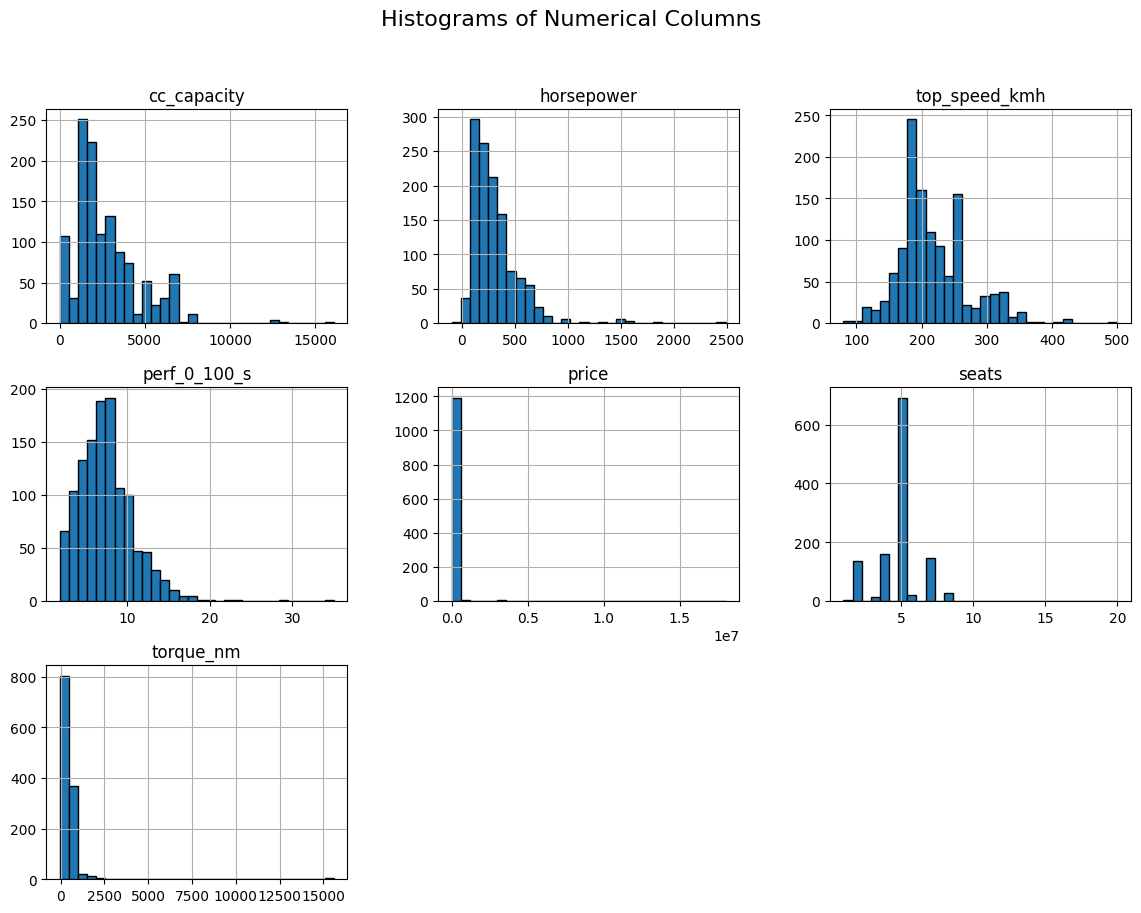

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Histograms ----------
df.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.show()


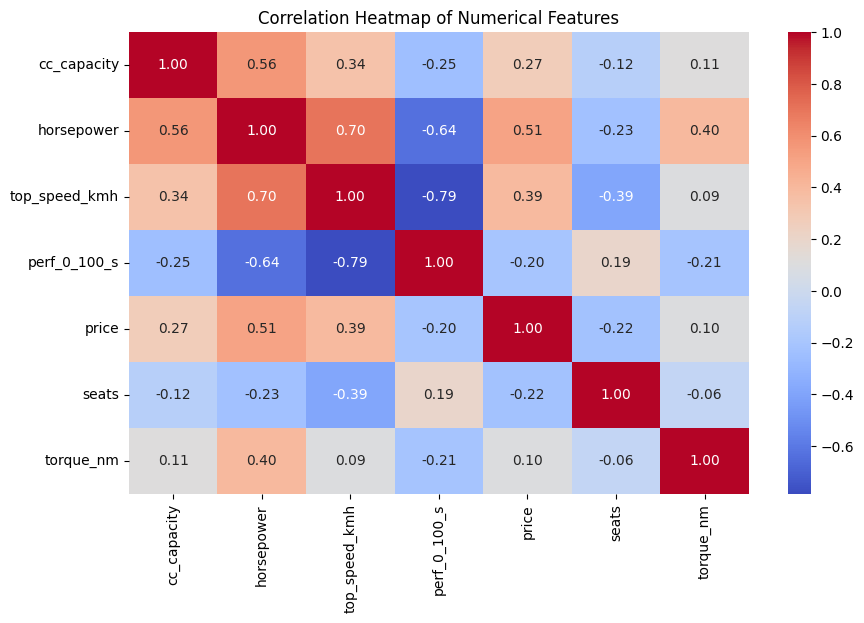

In [40]:
# ---------- Correlation Heatmap ----------
plt.figure(figsize=(10, 6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [41]:
# Count missing values per column
print(df.isna().sum())

# Percentage of missing values
print((df.isna().mean() * 100).round(2))


Company_Names     0
Cars_Names        0
Engines           0
cc_capacity       5
horsepower        0
top_speed_kmh     0
perf_0_100_s      6
price             1
Fuel_Types        0
seats            12
torque_nm         1
dtype: int64
Company_Names    0.00
Cars_Names       0.00
Engines          0.00
cc_capacity      0.41
horsepower       0.00
top_speed_kmh    0.00
perf_0_100_s     0.49
price            0.08
Fuel_Types       0.00
seats            0.99
torque_nm        0.08
dtype: float64


In [42]:
# Drop rows where critical columns are missing
df = df.dropna(subset=["Cars_Names", "Company_Names","cc_capacity","perf_0_100_s","seats"])

# Count missing values per column
print(df.isna().sum())

# Percentage of missing values
print((df.isna().mean() * 100).round(2))

Company_Names    0
Cars_Names       0
Engines          0
cc_capacity      0
horsepower       0
top_speed_kmh    0
perf_0_100_s     0
price            0
Fuel_Types       0
seats            0
torque_nm        0
dtype: int64
Company_Names    0.0
Cars_Names       0.0
Engines          0.0
cc_capacity      0.0
horsepower       0.0
top_speed_kmh    0.0
perf_0_100_s     0.0
price            0.0
Fuel_Types       0.0
seats            0.0
torque_nm        0.0
dtype: float64


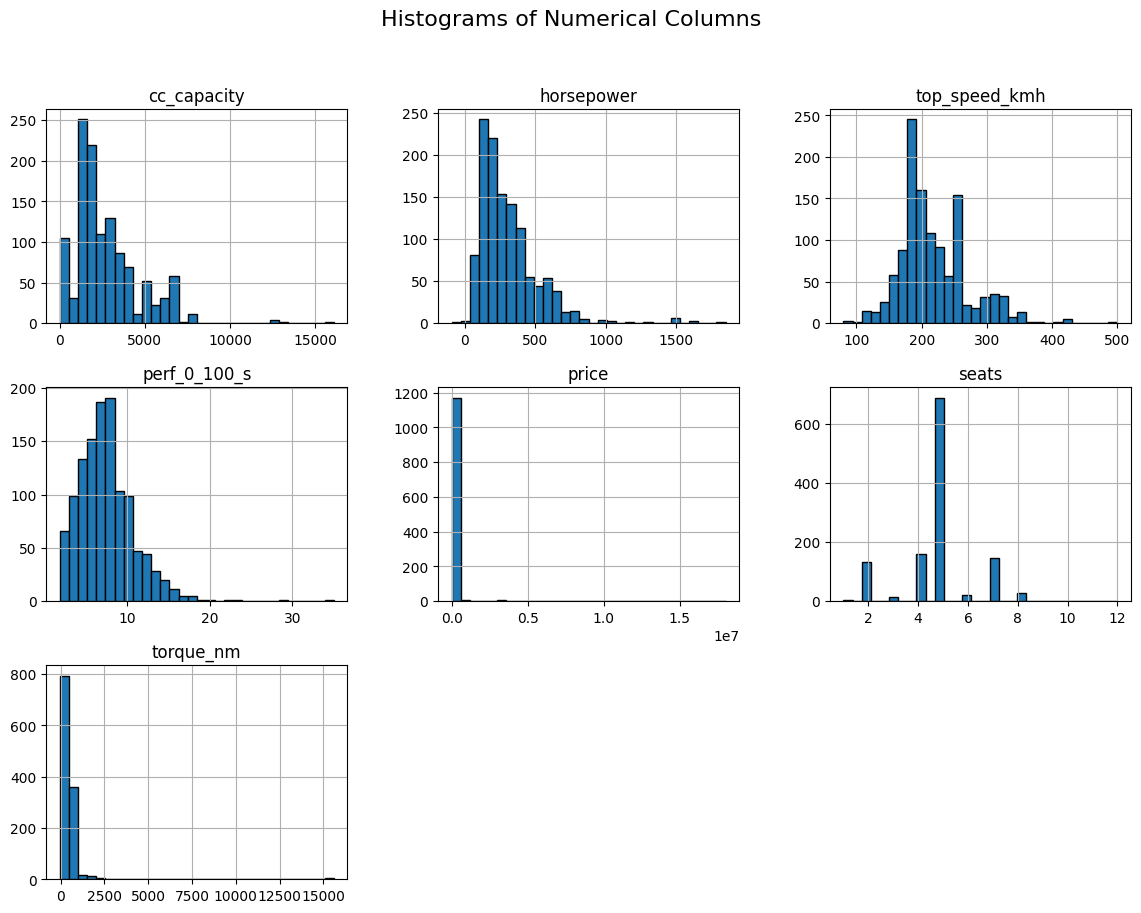

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Histograms ----------
df.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.show()

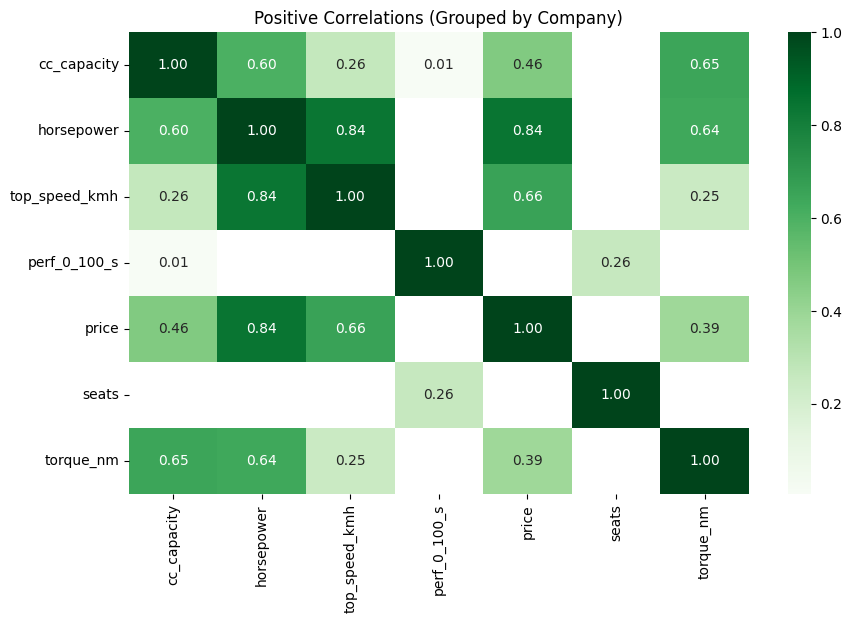

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# group by Company_Names and take mean of numeric cols
grouped = df.groupby("Company_Names").mean(numeric_only=True)

# compute correlation
corr = grouped.corr()

# filter only positive correlations (>0)
pos_corr = corr[corr > 0]

# plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pos_corr, annot=True, cmap="Greens", fmt=".2f")
plt.title("Positive Correlations (Grouped by Company)")
plt.show()


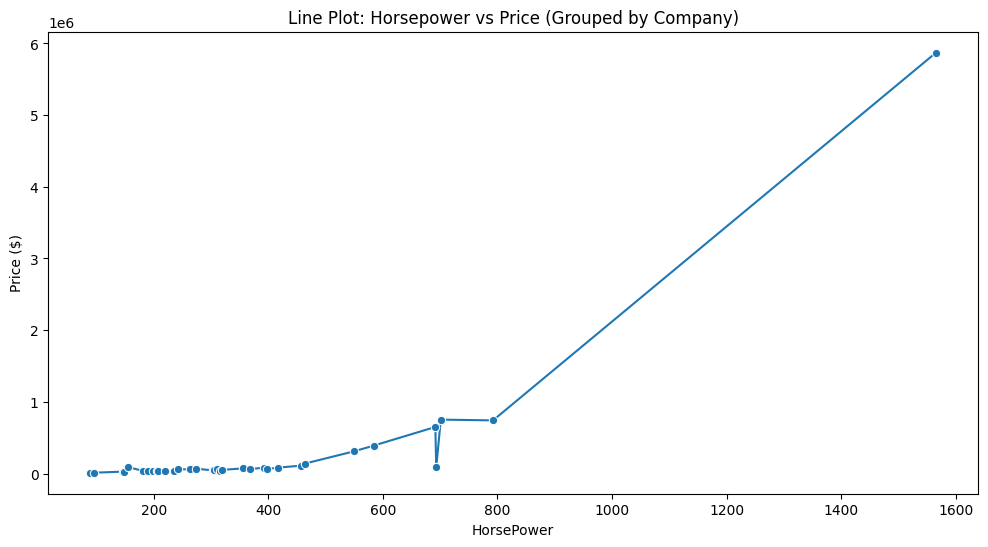

In [45]:
# Example line plot: avg HorsePower vs avg Price per company
plt.figure(figsize=(12,6))
sns.lineplot(data=grouped, x="horsepower", y="price", marker="o")
plt.title("Line Plot: Horsepower vs Price (Grouped by Company)")
plt.xlabel("HorsePower")
plt.ylabel("Price ($)")
plt.show()


In [48]:
df


,Company_Names,Cars_Names,Engines,cc_capacity,horsepower,top_speed_kmh,perf_0_100_s,price,Fuel_Types,seats,torque_nm,Fuel_Types_Code,Company_Code
0,FERRARI,SF90 STRADALE,V8,3990.0,963.0,340.0,2.50,1100000.0,plug in hyrbrid,2.0,800.0,20,8
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563.0,250.0,5.30,460000.0,Petrol,5.0,900.0,12,27
2,Ford,KA+,1.2L Petrol,1200.0,-7.5,165.0,10.50,-1500.0,Petrol,5.0,120.0,12,9
3,MERCEDES,GT 63 S,V8,3982.0,630.0,250.0,3.20,161000.0,Petrol,4.0,900.0,12,20
4,AUDI,AUDI R8 Gt,V10,5204.0,602.0,320.0,3.60,253290.0,Petrol,2.0,560.0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,Toyota,Crown Signia,2.5L Hybrid I4,2487.0,240.0,180.0,7.60,45795.0,Hybrid (Gas + Electric),5.0,239.0,6,31
1214,Toyota,4Runner (6th Gen),2.4L Turbo I4 (i-FORCE MAX Hybrid),2393.0,326.0,180.0,6.80,50000.0,Hybrid,7.0,630.0,5,31
1215,Toyota,Corolla Cross,2.0L Gas / 2.0L Hybrid,1987.0,182.5,190.0,8.60,27172.5,Gas / Hybrid,5.0,200.0,4,31
1216,Toyota,C-HR+,1.8L / 2.0L Hybrid,1798.0,169.0,180.0,9.20,33000.0,Hybrid,5.0,197.5,5,31


C:\Users\ASM9016\AppData\Local\Temp\ipykernel_13952\1312939187.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


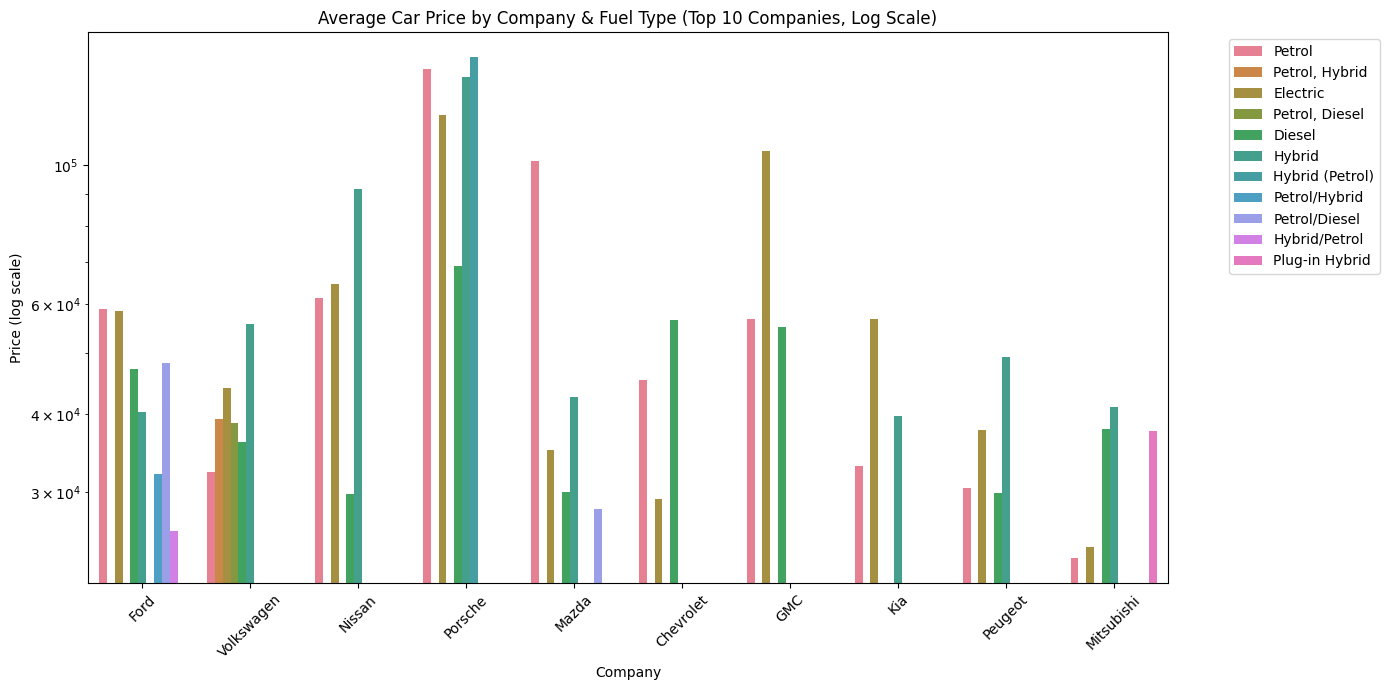

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Take top 10 companies by number of models
top_companies = df["Company_Names"].value_counts().nlargest(10).index
filtered = df[df["Company_Names"].isin(top_companies)]

plt.figure(figsize=(14,7))
sns.barplot(
    data=filtered,
    x="Company_Names",
    y="price",
    hue="Fuel_Types",
    ci=None
)

plt.yscale("log")   # log scale for better visibility
plt.xticks(rotation=45)
plt.title("Average Car Price by Company & Fuel Type (Top 10 Companies, Log Scale)")
plt.ylabel("Price (log scale)")
plt.xlabel("Company")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


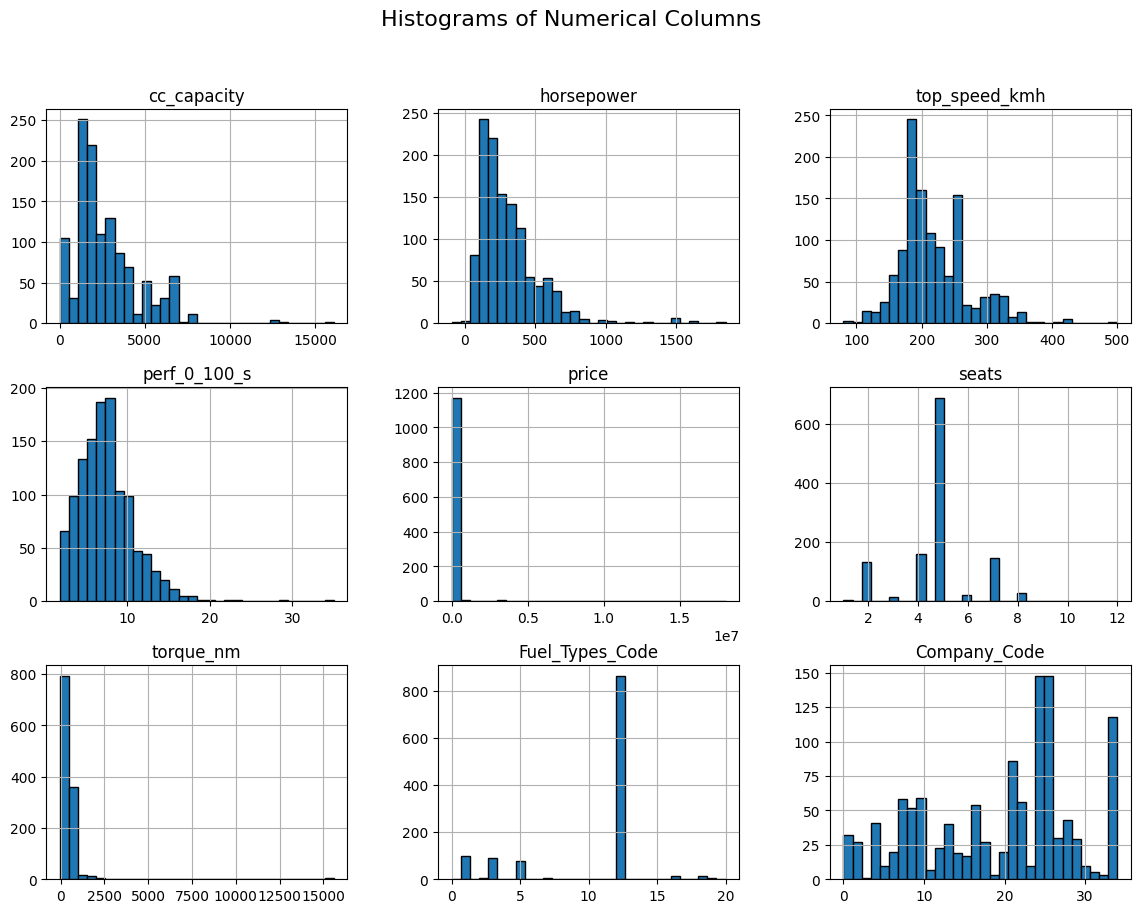

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Histograms ----------
df.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.show()


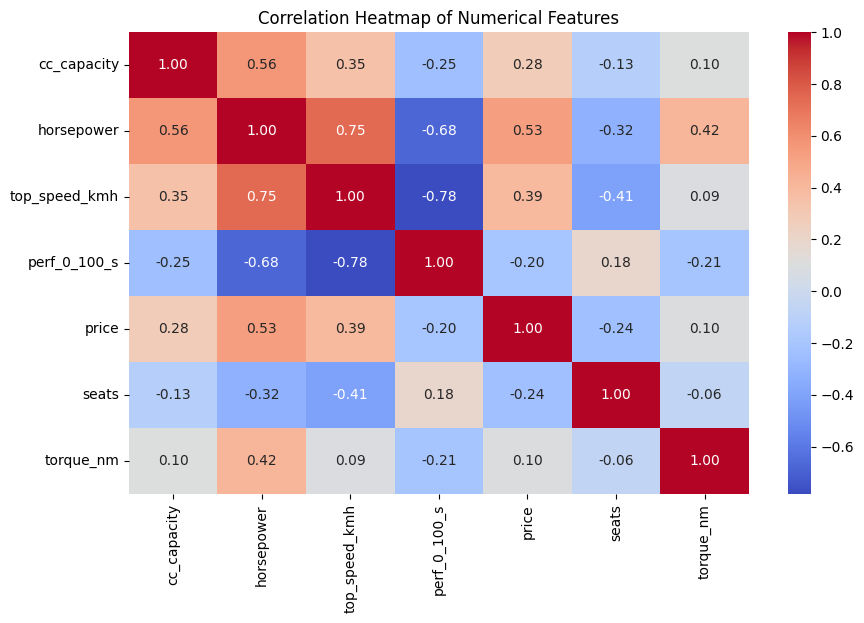

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns
num_df = df.select_dtypes(include=['float64','int64'])

# Compute correlation
corr = num_df.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()



CASE — Target = Company_Names
[Company_Names] Dropped rows for rare classes (<2): 1 (kept 34 classes)

--- Decision Tree ---
                   precision    recall  f1-score   support

     ASTON MARTIN       0.50      0.50      0.50         2
             AUDI       0.50      1.00      0.67         4
            Acura       1.00      1.00      1.00         5
              BMW       1.00      0.88      0.93         8
          Bugatti       1.00      1.00      1.00         2
         Cadillac       0.67      0.50      0.57         4
        Chevrolet       0.77      0.83      0.80        12
          FERRARI       0.00      0.00      0.00         1
             Ford       0.46      0.67      0.55         9
              GMC       0.75      1.00      0.86        12
            HONDA       0.00      0.00      0.00         1
          HYUNDAI       0.20      0.25      0.22         4
Jaguar Land Rover       1.00      1.00      1.00         8
             Jeep       1.00      0.25      0.4

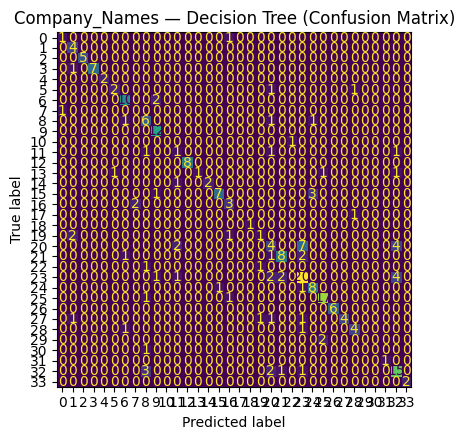


--- Random Forest ---
                   precision    recall  f1-score   support

     ASTON MARTIN       0.50      0.50      0.50         2
             AUDI       1.00      0.75      0.86         4
            Acura       0.80      0.80      0.80         5
              BMW       0.80      1.00      0.89         8
          Bugatti       1.00      1.00      1.00         2
         Cadillac       1.00      0.25      0.40         4
        Chevrolet       0.86      1.00      0.92        12
          FERRARI       0.00      0.00      0.00         1
             Ford       0.67      0.22      0.33         9
              GMC       0.73      0.92      0.81        12
            HONDA       0.00      0.00      0.00         1
          HYUNDAI       1.00      0.25      0.40         4
Jaguar Land Rover       1.00      1.00      1.00         8
             Jeep       1.00      0.25      0.40         4
              KIA       1.00      1.00      1.00         3
              Kia       0.78    

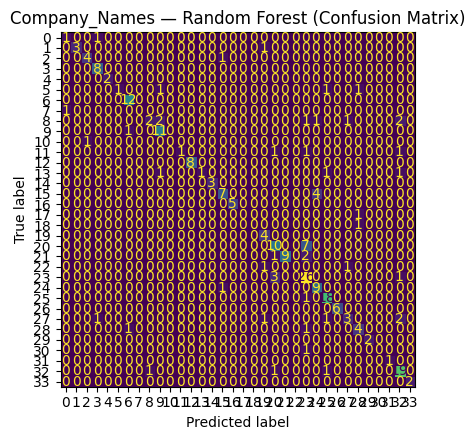


--- KNN ---
                   precision    recall  f1-score   support

     ASTON MARTIN       0.00      0.00      0.00         2
             AUDI       0.00      0.00      0.00         4
            Acura       0.00      0.00      0.00         5
              BMW       0.00      0.00      0.00         8
          Bugatti       1.00      0.50      0.67         2
         Cadillac       0.00      0.00      0.00         4
        Chevrolet       0.00      0.00      0.00        12
          FERRARI       0.00      0.00      0.00         1
             Ford       0.00      0.00      0.00         9
              GMC       0.00      0.00      0.00        12
            HONDA       0.00      0.00      0.00         1
          HYUNDAI       0.00      0.00      0.00         4
Jaguar Land Rover       0.00      0.00      0.00         8
             Jeep       0.00      0.00      0.00         4
              KIA       0.00      0.00      0.00         3
              Kia       0.00      0.00    

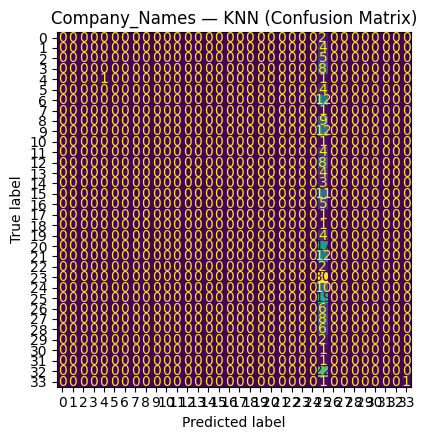


Summary for target: Company_Names
          Target          Model  Accuracy  Precision    Recall        F1
0  Company_Names  Random Forest  0.761506   0.756199  0.761506  0.734988
1  Company_Names  Decision Tree  0.677824   0.679775  0.677824  0.666191
2  Company_Names            KNN  0.087866   0.023110  0.087866  0.022958

CASE — Target = Fuel_Types
[Fuel_Types] Dropped rows for rare classes (<2): 10 (kept 13 classes)

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.29      0.19      0.23        21
           1       0.00      0.00      0.00         1
           2       0.14      0.05      0.08        19
           3       0.17      0.07      0.10        15
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.75      0.89      0.81       171
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
          1

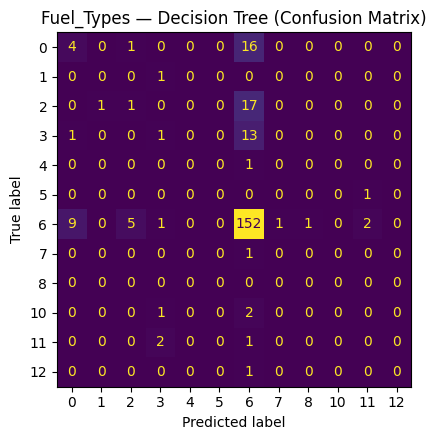


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.25      0.05      0.08        21
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        19
           3       1.00      0.07      0.12        15
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.73      0.99      0.84       171
           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1

    accuracy                           0.72       237
   macro avg       0.18      0.10      0.09       237
weighted avg       0.61      0.72      0.62       237



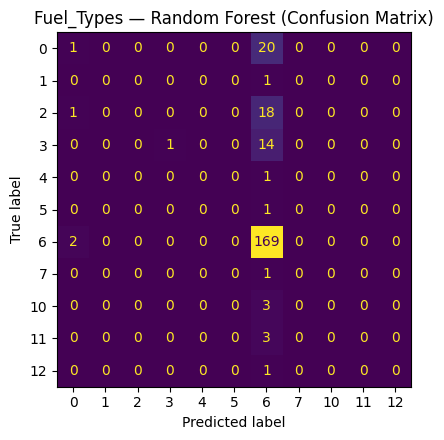


--- KNN ---
              precision    recall  f1-score   support

           0       1.00      0.05      0.09        21
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.72      1.00      0.84       171
           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1

    accuracy                           0.73       237
   macro avg       0.16      0.10      0.08       237
weighted avg       0.61      0.73      0.61       237



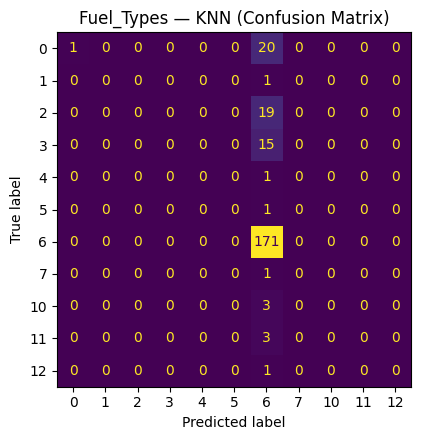


Summary for target: Fuel_Types
       Target          Model  Accuracy  Precision    Recall        F1
0  Fuel_Types  Random Forest  0.721519   0.611032  0.721519  0.620145
1  Fuel_Types  Decision Tree  0.666667   0.584920  0.666667  0.617359
2  Fuel_Types            KNN  0.725738   0.611403  0.725738  0.614344


================= OVERALL COMPARISON =================
          Target          Model  Accuracy  Precision    Recall        F1
0  Company_Names  Random Forest  0.761506   0.756199  0.761506  0.734988
1  Company_Names  Decision Tree  0.677824   0.679775  0.677824  0.666191
2  Company_Names            KNN  0.087866   0.023110  0.087866  0.022958
3     Fuel_Types  Random Forest  0.721519   0.611032  0.721519  0.620145
4     Fuel_Types  Decision Tree  0.666667   0.584920  0.666667  0.617359
5     Fuel_Types            KNN  0.725738   0.611403  0.725738  0.614344


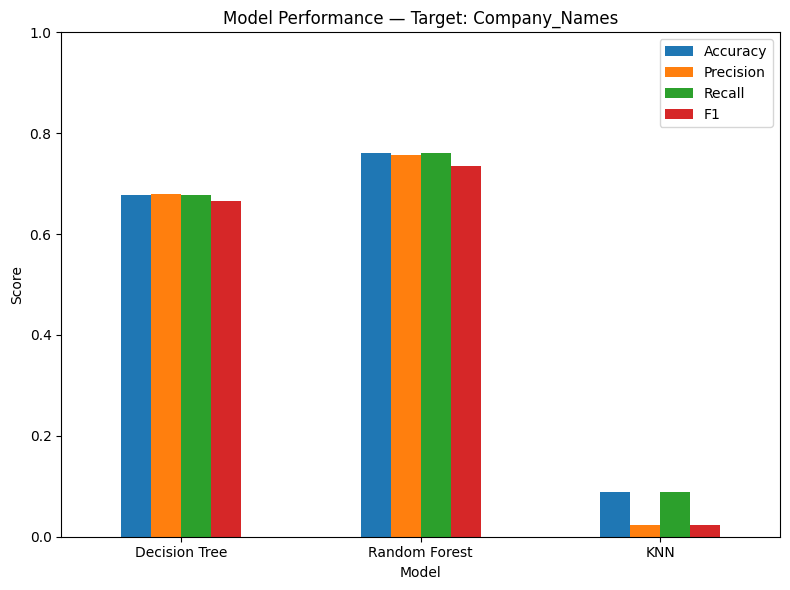

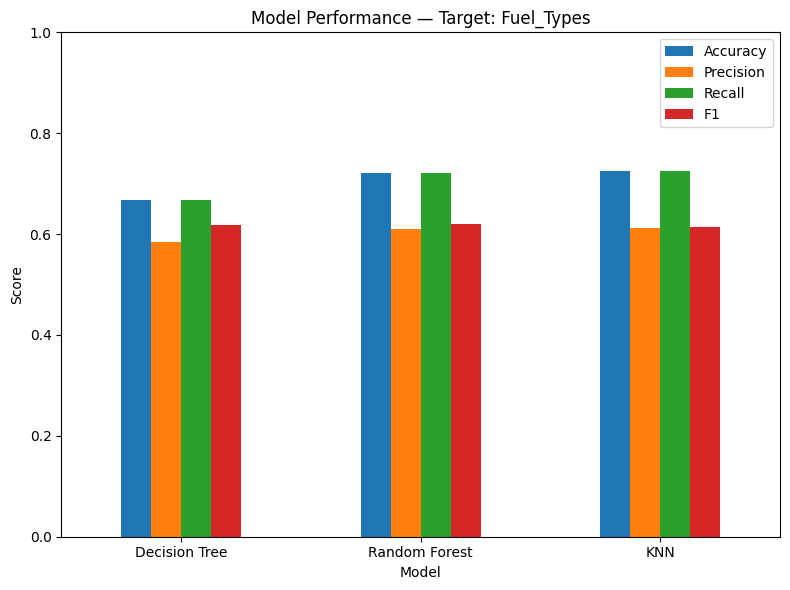

In [62]:
# ====================== CARS: MULTI-TARGET CLASSIFICATION (robust) ======================
# Drops rare classes (counts < MIN_CLASS_COUNT) to allow stratified split.
# Models: Decision Tree, Random Forest, KNN
# Metrics: Accuracy, Precision, Recall, F1 (weighted)
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# ----------------- CONFIG -----------------
FILE = "CarsDatasetCleaned.csv"
CASES = ["Company_Names", "Fuel_Types"]  # Case 1 & Case 2
MODELS = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
}
TEST_SIZE = 0.2
RANDOM_STATE = 42
MIN_CLASS_COUNT = 2   # must be >=2 for stratified split; raise to 3+ if you want safer class presence

# ----------------- LOAD -----------------
df = pd.read_csv(FILE)

def drop_rare_classes(df: pd.DataFrame, target_col: str, min_count: int) -> pd.DataFrame:
    """Keep only rows whose target class has at least min_count samples."""
    counts = df[target_col].value_counts(dropna=False)
    keep_classes = counts[counts >= min_count].index
    df2 = df[df[target_col].isin(keep_classes)].copy()
    dropped = len(df) - len(df2)
    print(f"[{target_col}] Dropped rows for rare classes (<{min_count}): {dropped} "
          f"(kept {len(keep_classes)} classes)")
    return df2

def run_case(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found. Available: {list(df.columns)}")

    print("\n" + "="*90)
    print(f"CASE — Target = {target_col}")
    print("="*90)

    # Drop rare classes before encoding/splitting
    df_case = drop_rare_classes(df, target_col, MIN_CLASS_COUNT)

    # Features/target
    X_raw = df_case.drop(columns=[target_col]).copy()
    y_raw = df_case[target_col].copy()

    # Encode target if needed
    if y_raw.dtype == "object":
        le = LabelEncoder()
        y = le.fit_transform(y_raw)
        class_names = le.classes_.astype(str).tolist()
    else:
        y = y_raw.to_numpy()
        class_names = sorted(pd.Series(y).unique().astype(str).tolist())

    # One-hot encode categorical predictors (all non-numeric columns in X_raw)
    cat_cols = X_raw.select_dtypes(include=["object", "category"]).columns.tolist()
    X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=False)

    # Remove any remaining rows with NaNs across features/target
    mask = X.notna().all(axis=1) & pd.Series(y).notna()
    X = X.loc[mask]
    y = np.array(pd.Series(y).loc[mask])

    # If still failing (e.g., some class now has <2 after mask), drop rare again
    # (rare after masking)
    tmp = pd.DataFrame({"y": y})
    counts_post = tmp["y"].value_counts()
    if (counts_post < 2).any():
        valid_labels = counts_post[counts_post >= 2].index
        sel = tmp["y"].isin(valid_labels).values
        X, y = X.iloc[sel], y[sel]
        # If too few classes remain, bail gracefully
        if len(np.unique(y)) < 2:
            print("Not enough classes remaining to train. Skipping this case.")
            return pd.DataFrame(columns=["Target","Model","Accuracy","Precision","Recall","F1"])

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    # Scale only for KNN
    scaler = StandardScaler(with_mean=False)
    X_train_knn = scaler.fit_transform(X_train)
    X_test_knn = scaler.transform(X_test)

    # Train & evaluate
    rows = []
    for name, model in MODELS.items():
        if name == "KNN":
            model.fit(X_train_knn, y_train)
            y_pred = model.predict(X_test_knn)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1   = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        print(f"\n--- {name} ---")
        try:
            print(classification_report(y_test, y_pred, target_names=[str(c) for c in class_names], zero_division=0))
        except Exception:
            print(classification_report(y_test, y_pred, zero_division=0))

        fig, ax = plt.subplots(figsize=(5.5, 4.5))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)
        ax.set_title(f"{target_col} — {name} (Confusion Matrix)")
        plt.tight_layout()
        plt.show()

        rows.append([target_col, name, acc, prec, rec, f1])

    case_df = pd.DataFrame(rows, columns=["Target", "Model", "Accuracy", "Precision", "Recall", "F1"])
    print("\nSummary for target:", target_col)
    print(case_df.sort_values("F1", ascending=False).reset_index(drop=True))
    return case_df

# ----------------- RUN BOTH CASES -----------------
all_results = []
for tgt in CASES:
    case_df = run_case(df, tgt)
    all_results.append(case_df)

results_df = pd.concat(all_results, ignore_index=True)

print("\n\n================= OVERALL COMPARISON =================")
print(results_df.sort_values(["Target", "F1"], ascending=[True, False]).reset_index(drop=True))

# Plot by target
for tgt in CASES:
    sub = results_df[results_df["Target"] == tgt].set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]]
    ax = sub.plot(kind="bar", figsize=(8, 6))
    ax.set_ylim(0, 1)
    ax.set_ylabel("Score")
    ax.set_title(f"Model Performance — Target: {tgt}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [64]:
!pip install imbalanced-learn


In [65]:
import imblearn
print(imblearn.__version__)


0.14.0


Loaded shape: (1218, 11)
Columns: ['Company_Names', 'Cars_Names', 'Engines', 'cc_capacity', 'horsepower', 'top_speed_kmh', 'perf_0_100_s', 'price', 'Fuel_Types', 'seats', 'torque_nm']
Outlier removal: removed 43 rows with |z| >= 3.0

CASE — Target = Company_Names
Class distribution AFTER oversampling:
0     145
1     145
2     145
3     145
4     145
5     145
6     145
7     145
8     145
9     145
10    145
11    145
12    145
13    145
14    145
15    145
16    145
17    145
18    145
19    145
20    145
21    145
22    145
23    145
24    145
25    145
26    145
27    145
28    145
29    145
30    145
31    145
32    145
Name: count, dtype: int64

--- Decision Tree ---
                   precision    recall  f1-score   support

     ASTON MARTIN       1.00      1.00      1.00        29
             AUDI       1.00      0.97      0.98        29
            Acura       0.97      1.00      0.98        29
          BENTLEY       1.00      1.00      1.00        29
              BMW     

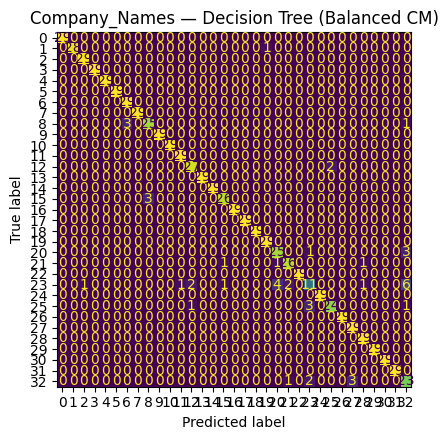


--- Random Forest ---
                   precision    recall  f1-score   support

     ASTON MARTIN       1.00      1.00      1.00        29
             AUDI       1.00      1.00      1.00        29
            Acura       1.00      1.00      1.00        29
          BENTLEY       1.00      1.00      1.00        29
              BMW       1.00      1.00      1.00        29
         Cadillac       1.00      1.00      1.00        29
        Chevrolet       1.00      0.86      0.93        29
          FERRARI       1.00      1.00      1.00        29
             Ford       0.96      0.86      0.91        29
              GMC       0.85      1.00      0.92        29
            HONDA       1.00      1.00      1.00        29
          HYUNDAI       0.91      1.00      0.95        29
Jaguar Land Rover       1.00      1.00      1.00        29
             Jeep       1.00      1.00      1.00        29
              KIA       0.91      1.00      0.95        29
              Kia       0.90    

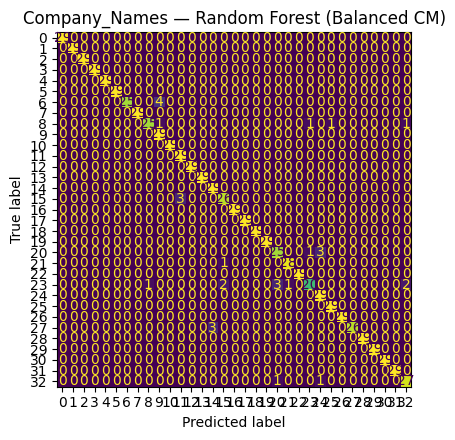


--- KNN ---
                   precision    recall  f1-score   support

     ASTON MARTIN       1.00      1.00      1.00        29
             AUDI       1.00      0.86      0.93        29
            Acura       1.00      0.83      0.91        29
          BENTLEY       0.08      1.00      0.16        29
              BMW       1.00      0.45      0.62        29
         Cadillac       1.00      0.90      0.95        29
        Chevrolet       1.00      0.21      0.34        29
          FERRARI       1.00      1.00      1.00        29
             Ford       1.00      0.34      0.51        29
              GMC       1.00      0.41      0.59        29
            HONDA       1.00      1.00      1.00        29
          HYUNDAI       1.00      0.83      0.91        29
Jaguar Land Rover       1.00      0.45      0.62        29
             Jeep       1.00      0.83      0.91        29
              KIA       1.00      1.00      1.00        29
              Kia       1.00      0.45    

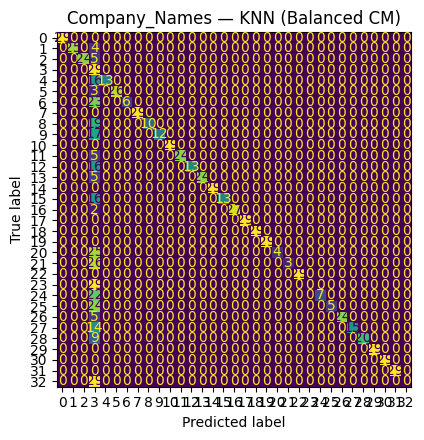


Summary for target: Company_Names
          Target          Model  Accuracy  Precision    Recall        F1
0  Company_Names  Random Forest  0.968652   0.969869  0.968652  0.968030
1  Company_Names  Decision Tree  0.951933   0.949876  0.951933  0.949388
2  Company_Names            KNN  0.671891   0.911653  0.671891  0.712833

CASE — Target = Fuel_Types
Class distribution AFTER oversampling:
0     845
1     845
3     845
4     845
5     845
6     845
7     845
8     845
9     845
10    845
11    845
12    845
13    845
15    845
16    845
17    845
18    845
19    845
20    845
21    845
22    845
Name: count, dtype: int64

--- Decision Tree ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       169
           1       0.99      1.00      0.99       169
           3       1.00      1.00      1.00       169
           4       1.00      1.00      1.00       169
           5       1.00      1.00      1.00       169
           6       0.9

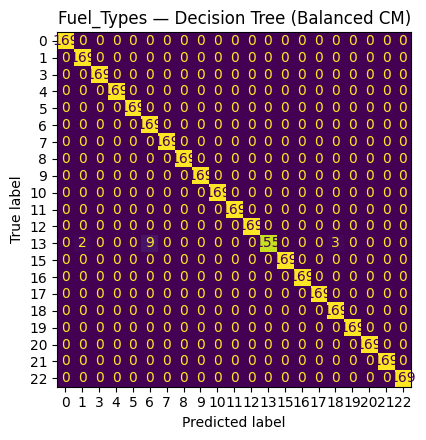


--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       169
           1       0.97      1.00      0.99       169
           3       1.00      1.00      1.00       169
           4       1.00      1.00      1.00       169
           5       1.00      1.00      1.00       169
           6       0.99      1.00      1.00       169
           7       1.00      1.00      1.00       169
           8       1.00      1.00      1.00       169
           9       1.00      1.00      1.00       169
          10       1.00      1.00      1.00       169
          11       1.00      1.00      1.00       169
          12       1.00      1.00      1.00       169
          13       1.00      0.96      0.98       169
          15       1.00      1.00      1.00       169
          16       1.00      1.00      1.00       169
          17       1.00      1.00      1.00       169
          18       1.00      1.00      1.00       169
    

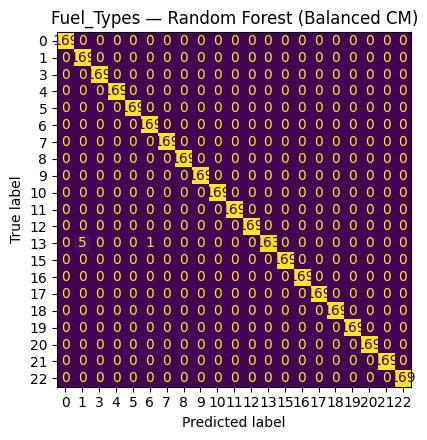


--- KNN ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       169
           1       1.00      0.99      0.99       169
           3       1.00      1.00      1.00       169
           4       1.00      1.00      1.00       169
           5       0.82      1.00      0.90       169
           6       1.00      1.00      1.00       169
           7       0.98      1.00      0.99       169
           8       1.00      1.00      1.00       169
           9       0.67      1.00      0.80       169
          10       0.99      1.00      1.00       169
          11       0.97      1.00      0.99       169
          12       0.92      1.00      0.96       169
          13       0.00      0.00      0.00       169
          15       0.99      1.00      1.00       169
          16       0.98      1.00      0.99       169
          17       1.00      1.00      1.00       169
          18       1.00      1.00      1.00       169
          19  

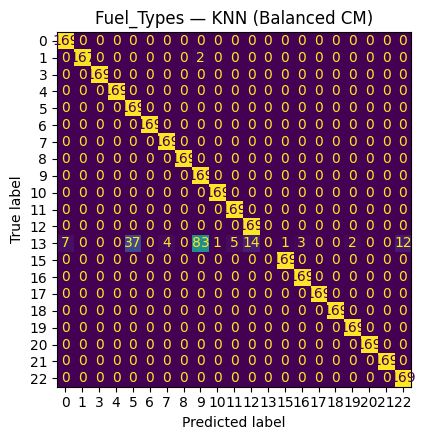


Summary for target: Fuel_Types
       Target          Model  Accuracy  Precision    Recall        F1
0  Fuel_Types  Random Forest  0.998309   0.998352  0.998309  0.998305
1  Fuel_Types  Decision Tree  0.996055   0.996205  0.996055  0.996008
2  Fuel_Types            KNN  0.951817   0.914781  0.951817  0.931106


======================= OVERALL COMPARISON =======================
          Target          Model  Accuracy  Precision    Recall        F1
0  Company_Names  Random Forest  0.968652   0.969869  0.968652  0.968030
1  Company_Names  Decision Tree  0.951933   0.949876  0.951933  0.949388
2  Company_Names            KNN  0.671891   0.911653  0.671891  0.712833
3     Fuel_Types  Random Forest  0.998309   0.998352  0.998309  0.998305
4     Fuel_Types  Decision Tree  0.996055   0.996205  0.996055  0.996008
5     Fuel_Types            KNN  0.951817   0.914781  0.951817  0.931106


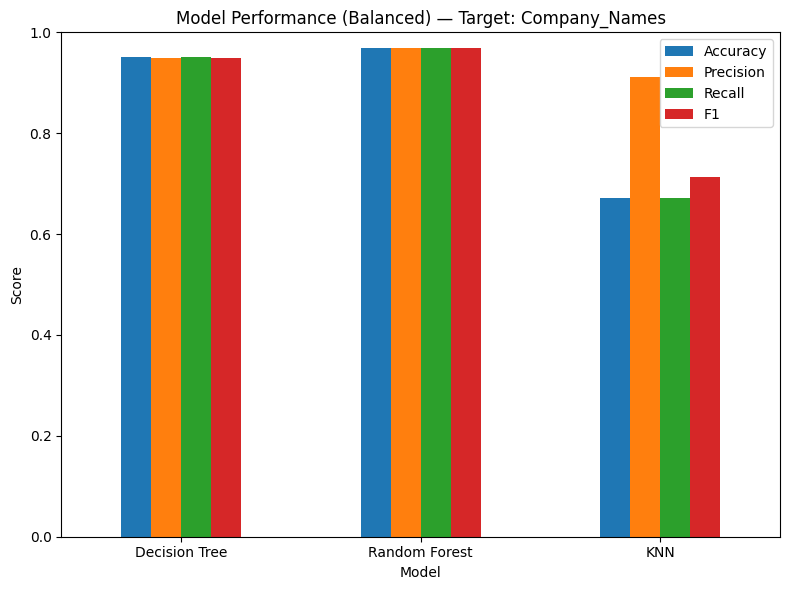

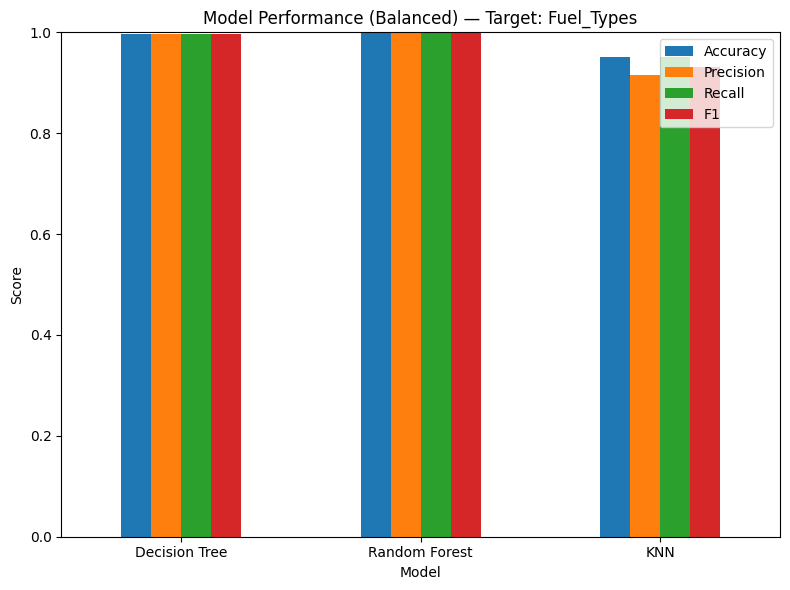

In [66]:
# ================== BALANCED CLASSIFICATION: CARS DATASET ==================
# Steps:
#   1) Load cleaned CSV
#   2) Remove numeric outliers via Z-score threshold
#   3) Balance classes via SMOTE (or fall back to RandomOverSampler if too few samples)
#   4) Train Decision Tree, Random Forest, KNN (with scaling only for KNN)
#   5) Compare metrics & visualize confusion matrices + bar charts
# ===========================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import zscore
from imblearn.over_sampling import SMOTE, RandomOverSampler

# --------------------------- CONFIG ---------------------------
FILE = "CarsDatasetCleaned.csv"

# Two classification cases to run:
CASES = ["Company_Names", "Fuel_Types"]

# Models to train:
MODELS = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
}

TEST_SIZE = 0.2
RANDOM_STATE = 42

# Outlier removal (standard deviation limit):
Z_THRESHOLD = 3.0  # keep rows where |z| < Z_THRESHOLD across numeric features

# SMOTE configuration:
SMOTE_DESIRED_K = 3  # we will adapt k_neighbors based on the smallest class count
# --------------------------------------------------------------


# --------------------------- LOAD ----------------------------
df = pd.read_csv(FILE)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))

# ----------------- GLOBAL OUTLIER REMOVAL (numeric) ----------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    zscores = np.abs(zscore(df[numeric_cols], nan_policy='omit'))
    # keep rows where every available numeric feature is within threshold
    # (rows with NaN z for a feature are treated as False in the .all(axis=1) mask,
    #  so we explicitly handle NaNs by replacing NaN z with 0 for the mask purpose)
    zscores = np.nan_to_num(zscores, nan=0.0)
    keep_mask = (zscores < Z_THRESHOLD).all(axis=1)
    removed = int((~keep_mask).sum())
    df = df.loc[keep_mask].reset_index(drop=True)
    print(f"Outlier removal: removed {removed} rows with |z| >= {Z_THRESHOLD}")
else:
    print("No numeric columns found for outlier removal.")

# --------------------- UTILITIES -----------------------------
def choose_oversampler(y, desired_k=SMOTE_DESIRED_K, random_state=RANDOM_STATE):
    """Return SMOTE with a safe k_neighbors if possible, else RandomOverSampler."""
    counts = pd.Series(y).value_counts()
    min_count = counts.min()

    # If a class has 0/1 samples (shouldn't happen for current y), ROS is safest.
    if min_count <= 1:
        return RandomOverSampler(random_state=random_state)

    # SMOTE requires k_neighbors <= (min_class_count - 1) and >= 1
    k_eff = max(1, min(desired_k, int(min_count) - 1))
    return SMOTE(random_state=random_state, k_neighbors=k_eff)

def run_case(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found. Available: {list(df.columns)}")

    print("\n" + "="*100)
    print(f"CASE — Target = {target_col}")
    print("="*100)

    # -------- Split features/target --------
    X_raw = df.drop(columns=[target_col]).copy()
    y_raw = df[target_col].copy()

    # Optionally drop ID-like features (e.g., car names) if you don't want them as predictors:
    # X_raw = X_raw.drop(columns=["Cars_Names"], errors="ignore")

    # -------- Encode target if needed --------
    if y_raw.dtype == "object":
        le = LabelEncoder()
        y = le.fit_transform(y_raw)
        class_names = le.classes_.astype(str).tolist()
    else:
        y = y_raw.to_numpy()
        class_names = sorted(pd.Series(y).unique().astype(str).tolist())

    # -------- One-hot encode categorical predictors --------
    cat_cols = X_raw.select_dtypes(include=["object", "category"]).columns.tolist()
    X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=False)

    # Remove any rows with NaNs across predictors/target
    mask = X.notna().all(axis=1) & pd.Series(y).notna()
    X = X.loc[mask]
    y = np.array(pd.Series(y).loc[mask])

    # -------- Balance with oversampling --------
    oversampler = choose_oversampler(y)
    X_bal, y_bal = oversampler.fit_resample(X, y)
    print("Class distribution AFTER oversampling:")
    print(pd.Series(y_bal).value_counts().sort_index())

    # -------- Train/test split (after balancing) --------
    X_train, X_test, y_train, y_test = train_test_split(
        X_bal, y_bal, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_bal
    )

    # -------- Scaling (only for KNN) --------
    scaler = StandardScaler(with_mean=False)  # safe for sparse one-hot matrices
    X_train_knn = scaler.fit_transform(X_train)
    X_test_knn = scaler.transform(X_test)

    # -------- Train & Evaluate --------
    rows = []
    for name, model in MODELS.items():
        if name == "KNN":
            model.fit(X_train_knn, y_train)
            y_pred = model.predict(X_test_knn)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1   = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        print(f"\n--- {name} ---")
        # Try printing with class names; fall back if mismatch
        try:
            print(classification_report(y_test, y_pred, target_names=[str(c) for c in class_names], zero_division=0))
        except Exception:
            print(classification_report(y_test, y_pred, zero_division=0))

        fig, ax = plt.subplots(figsize=(5.5, 4.5))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)
        ax.set_title(f"{target_col} — {name} (Balanced CM)")
        plt.tight_layout()
        plt.show()

        rows.append([target_col, name, acc, prec, rec, f1])

    case_df = pd.DataFrame(rows, columns=["Target", "Model", "Accuracy", "Precision", "Recall", "F1"])
    print("\nSummary for target:", target_col)
    print(case_df.sort_values("F1", ascending=False).reset_index(drop=True))
    return case_df

# -------------------- RUN BOTH CASES --------------------
all_results = []
for tgt in CASES:
    case_df = run_case(df, tgt)
    all_results.append(case_df)

results_df = pd.concat(all_results, ignore_index=True)

print("\n\n======================= OVERALL COMPARISON =======================")
print(results_df.sort_values(["Target", "F1"], ascending=[True, False]).reset_index(drop=True))

# -------------------- BAR PLOTS BY TARGET --------------------
for tgt in CASES:
    sub = results_df[results_df["Target"] == tgt].set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]]
    ax = sub.plot(kind="bar", figsize=(8, 6))
    ax.set_ylim(0, 1)
    ax.set_ylabel("Score")
    ax.set_title(f"Model Performance (Balanced) — Target: {tgt}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
